In [34]:
import re, glob, os, pathlib, subprocess,time
import pandas as pd
import msgpack
# import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib
import matplotlib.collections as mcol
import math
import numpy as np
import seaborn as sns
import networkx as nx
from IPython.display import Image, display

In [52]:
__directory__ = "/home/leo/Dev/Data_Stream/2018/04/"
__filedate__ = "20180418"

__directory__ = "/home/leo/Dev/Data_Stream/"+"Socio_Patterns/High_School_2013/"
__filedate__="High_School_2013"

# __directory__ = "/home/leo/Dev/Data_Stream/"+"Socio_Patterns/Workplace/"
# __filedate__ ="Workplace"

# __directory__ = "/home/leo/Dev/Data_Stream/Rollernet/"
# __filedate__ = "rollernet"
__directory__ = "/home/leo/Dev/Data_Stream/Infocom/"
__filedate__ = "infocom"


preprocess_data = __directory__+"preprocess_data/"
figures_data = __directory__+"figures/"
scc_storage = __directory__+__filedate__+"_scc_storage/"
dag_storage = __directory__+__filedate__+"_scc_dag_storage/"
offset_storage = dag_storage+"dict_offset.mpck"

In [28]:
def plot(SD_nodes,SD_links):
    g_adjacency_list = {n: [] for n in SD_nodes}
    if SD_links:
#         G = nx.DiGraph()
        for l in SD_links:
            n1 = l[0]
            n2 = l[1]
#             G.add_edge(n1,n2)
            g_adjacency_list[n1].append(n2)
#             g_adjacency_list[n2].append(n1)
        G = nx.from_dict_of_lists(g_adjacency_list)
        pos = nx.kamada_kawai_layout(G)
#         nx.draw_networkx_labels(G_glob, pos, font_size=15)
        nx.draw_networkx_nodes(G, pos, node_size=50,
                                       node_color="#339966", alpha=0.5)
        nx.draw_networkx_edges(G, pos, edge_color='b',
                                       alpha=0.3, width=3,arrows=True)

In [29]:
def load_times_scc(id_wcc,id_scc,scc_storage,dict_offset):
    with open(scc_storage+'scc.scf','rb') as file_input:
        file_input.seek(dict_offset[(id_wcc,id_scc)])
        i = msgpack.Unpacker(file_input,use_list=False).unpack()
        times_scc = (i[2],i[3])
    return times_scc

In [30]:
def plot_scc_dag(id_wcc,SD_nodes,SD_links,offset_storage):
    dict_offset = msgpack.unpack(open(offset_storage,'rb'),use_list=False)
    ax = plt.gca()
    g_adjacency_list = {n: [] for n in SD_nodes}
    pos = {n : [] for n in SD_nodes}
    n_nodes= len(pos)
    y = 0
    # Get pos of each node 
    min_x = math.inf
    max_x = -math.inf
    for id_scc in SD_nodes:
        times_scc = load_times_scc(id_wcc,id_scc,scc_storage,dict_offset)
        t0,t1 = times_scc
        x = (t0+t1)/2
        min_x = min(min_x,t0)
        max_x = max(max_x,t1)
        pos[id_scc] = [x,y]
    # Get Adjacency list
    if SD_links:
        for l in SD_links:
            n1 = l[0]
            n2 = l[1]
            g_adjacency_list[n1].append(n2)
    # Plot nodes and links : plot nodes in increasing order
    # adjust 'y' depending on the number of neighbors
    visited =set()
    max_y = y
    E = list()
    for n,_ in sorted(pos.items(),key=lambda x:x[1][0]):
        offset_y = 0
        sens = 1
        for u in g_adjacency_list[n]:
            if u not in visited:
                x,y = pos[u]
                offset_y +=1
                y+=offset_y
                max_y = max(max_y,y)
                y *= -1
#                 ax.scatter(x,y,
#                            c="#339966",
#                            s=50,
#                            marker='s',
#                            alpha = 0.5
#                           )
                visited.add(u)
                pos[u] = (x,y)
            E.append((pos[n],pos[u]))
#         if n not in visited:
#             x,y = pos[n]
#             ax.scatter(x,y,
#                         c="#339966",
#                         s=50,
#                         marker='s',
#                         alpha = 0.5
#                         )
    
    xy = np.asarray([pos[v] for v in pos])
    print("BEGIN PLOT, POSITIONS CALCULATED")
    ax.scatter(xy[:,0], xy[:,1],
                c="#339966",
                s=50,
                marker='s',
                alpha = 0.5
                )
    print(" DRAWING NODES : DONE")
    edge_collections = mcol.LineCollection(E, colors=['#2d5986'], linewidths=2, alpha=0.5)
    ax.add_collection(edge_collections)
    print(" DRAWING EDGES : DONE")
    ax.set_ylim((-max_y-3,max_y+3))
    ax.set_xlim((min_x,max_x))
    ax.tick_params(right=False, left=False, labelleft=False, labelbottom=True)
    
            

ID WCC :  753  Number of Nodes :  25  Number of Links :  25
BEGIN PLOT, POSITIONS CALCULATED
 DRAWING NODES : DONE
 DRAWING EDGES : DONE


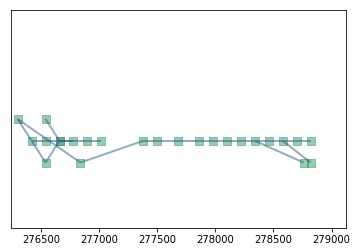

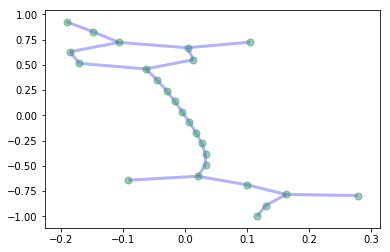

ID WCC :  805  Number of Nodes :  73  Number of Links :  75
BEGIN PLOT, POSITIONS CALCULATED
 DRAWING NODES : DONE
 DRAWING EDGES : DONE


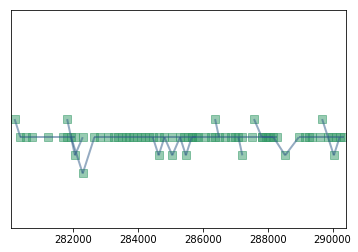

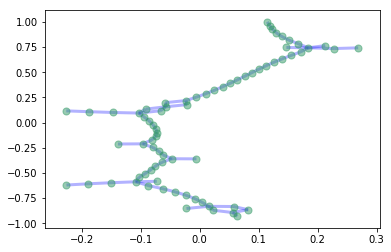

ID WCC :  874  Number of Nodes :  61  Number of Links :  60
BEGIN PLOT, POSITIONS CALCULATED
 DRAWING NODES : DONE
 DRAWING EDGES : DONE


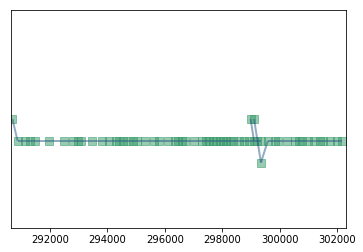

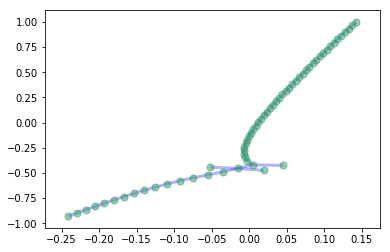

In [54]:
Unpacker = msgpack.Unpacker(open(dag_storage+"scc_dag_with_links.scf",'rb'),use_list=False)
saving_path = figures_data+"dag_plot"
format = "pdf"
distrib_nodes_dag = []
distrib_links_dag = []
occurences_nodes = defaultdict(int)
occurences_links = defaultdict(int)
for i in Unpacker:
    id_wcc = i[0]
    nodes = i[1]
    links = i[2]
    n_nodes = len(nodes)
    distrib_nodes_dag.append(n_nodes)
    n_links = len(links)
    distrib_links_dag.append(n_links)
    for n in nodes:
        occurences_nodes[n]+=1
    for l in links:
        occurences_links[l]+=1
    if 200>=n_nodes>=20 or 200>=n_links>=20:
        # Print big weakly component aka big graphs 
        print("ID WCC : ",id_wcc," Number of Nodes : ",n_nodes," Number of Links : ",n_links)
        fig = plt.figure()
        plot_scc_dag(id_wcc,nodes,links,offset_storage)
        fig.savefig(saving_path+str(id_wcc) + "_v1." + format, format=format,dpi=2400)
        plt.show()
        fig = plt.figure()
        plot(nodes,links)
        fig.savefig(saving_path+str(id_wcc) + "_v2." + format, format=format,dpi=2400)
        plt.show()
    set_nodes = set(i[1])
    set_nodes_in_links = set()
    for l in i[2]:
        set_nodes_in_links.add(l[0])
        set_nodes_in_links.add(l[1])
    if set_nodes != set_nodes_in_links:
        # Check if there is some isolated nodes in the SCC DAG
        print("ID WCC :",i[0])
        print("len set nodes :",len(set_nodes))
        print("len set nodes in links :",len(set_nodes_in_links))
        print("number of isolated nodes :",len(set_nodes-set_nodes_in_links))
    

### Histogram Number of Nodes per SCC

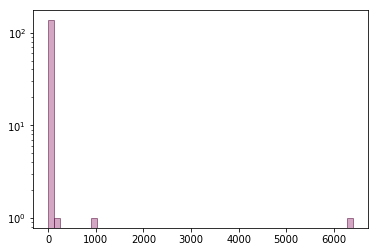

In [55]:
ax = sns.distplot(distrib_nodes_dag,hist_kws={'alpha': 0.5, 'ec': '#510438', 'fc': '#a8508b', 'linewidth': '1'}, kde=False)
ax.set(yscale='log')
plt.show()

### Histogram Nomber of Links per SCC

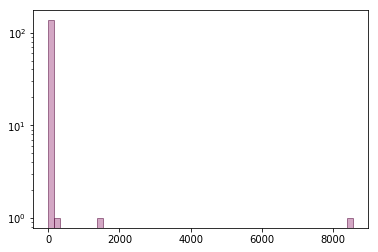

In [56]:
ax = sns.distplot(distrib_links_dag,hist_kws={'alpha': 0.5, 'ec': '#510438', 'fc': '#a8508b', 'linewidth': '1'}, kde=False)
ax.set(yscale='log')
plt.show()

### Histogram Occurences of Nodes among SCC

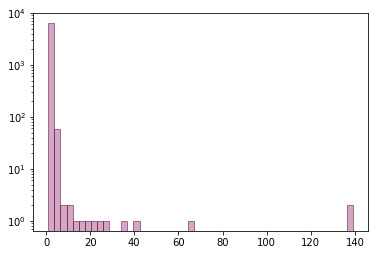

In [57]:
ax = sns.distplot(list(occurences_nodes.values()),hist_kws={'alpha': 0.5, 'ec': '#510438', 'fc': '#a8508b', 'linewidth': '1'}, kde=False)
ax.set(yscale='log')
plt.show()

### Histogram Occurences of Links among SCC

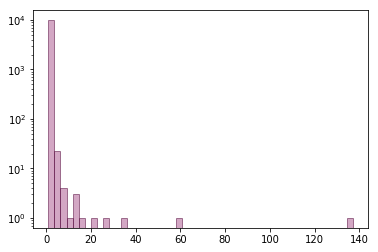

In [58]:
ax = sns.distplot(list(occurences_links.values()),hist_kws={'alpha': 0.5, 'ec': '#510438', 'fc': '#a8508b', 'linewidth': '1'}, kde=False)
ax.set(yscale='log')
plt.show()